# Install Dependencies

In [6]:
!pip install pytorch_lightning datasets torchmetrics matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [7]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModel,
    AdamW,
    get_cosine_schedule_with_warmup,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import F1Score, Recall
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

# Load and Prepare Data
## Data Loading & Preprocessing
### - Load tweet_eval dataset
### - Merge with custom CSV files
### - Handle missing values and data types

In [10]:
tweet_dataset = load_dataset('tweet_eval', 'sentiment')

# Load custom datasets
df_train = pd.read_csv("/content/drive/MyDrive/roBERTa/second_train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("/content/drive/MyDrive/roBERTa/second_test.csv", encoding="ISO-8859-1")

# Preprocessing
sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}

for df in [df_train, df_test]:
    df['label'] = df['sentiment'].map(sentiment_mapping)
    df.dropna(subset=['text', 'label'], inplace=True)
    df['text'] = df['text'].astype(str)

# Merge datasets
merged_train = pd.concat([tweet_dataset['train'].to_pandas(), df_train[['text', 'label']]], ignore_index=True)
merged_test = pd.concat([tweet_dataset['test'].to_pandas(), df_test[['text', 'label']]], ignore_index=True)

# Clean data
for df in [merged_train, merged_test]:
    df.drop_duplicates(subset=['text'], inplace=True)
    df.dropna(subset=['text'], inplace=True)

# Data Visualization
## Data Distribution
### - Class distribution visualization
### - Text length analysis

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

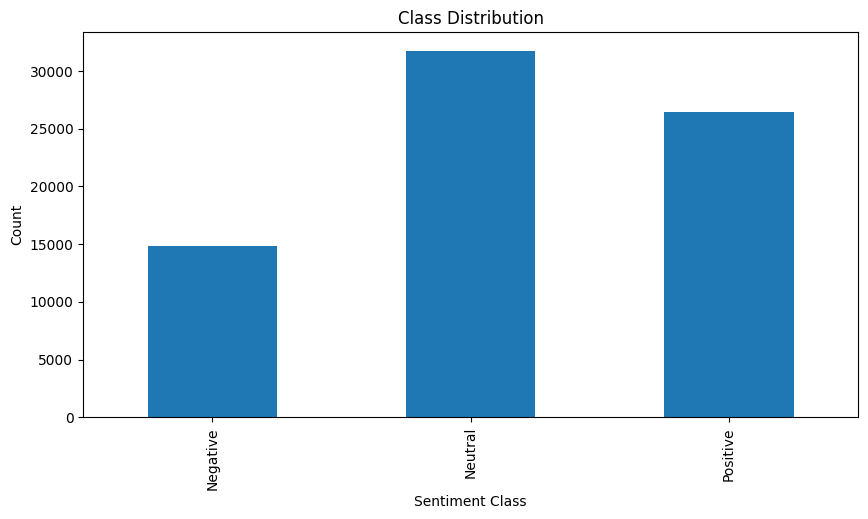

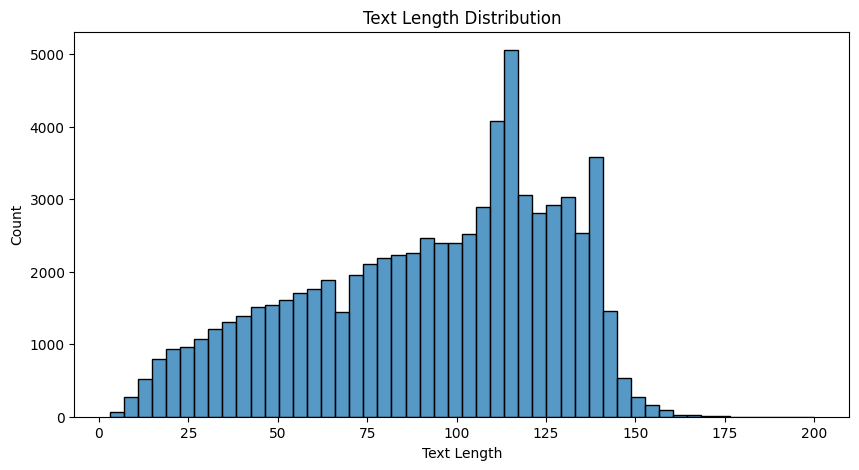

In [13]:
# Class distribution
plt.figure(figsize=(10, 5))
plt.title("Class Distribution")
merged_train['label'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

# Text length analysis
merged_train['text_length'] = merged_train['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.title("Text Length Distribution")
sns.histplot(merged_train['text_length'], bins=50)
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()


# Tokenization Setup
## Tokenization Configuration
### - Roberta-base tokenizer
### - Dynamic padding setup

In [15]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

class TweetDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      text = self.data.iloc[idx]['text']
      label = self.data.iloc[idx]['label']
      encoding = self.tokenizer(text, truncation=True, max_length=256)
      return {
          'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'labels': torch.tensor(label, dtype=torch.long)
      }

# Data Module
## Data Loaders
### - Batch size 16
### - Dynamic padding
### - 80-10-10 split

In [16]:
class TweetDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, val_df, batch_size=16):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    def setup(self, stage=None):
        self.train_dataset = TweetDataset(self.train_df, tokenizer)
        self.val_dataset = TweetDataset(self.val_df, tokenizer)
        self.test_dataset = TweetDataset(self.test_df, tokenizer)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                         collate_fn=data_collator, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                        collate_fn=data_collator, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                         collate_fn=data_collator, num_workers=2)

# Enhanced Model Architecture
## Model Architecture
### - Roberta-base with mean pooling
### - Dropout regularization
### - Class weights handling

In [17]:
class SentimentClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, class_weights=None):
        super().__init__()
        self.save_hyperparameters()

        self.roberta = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        # Metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes)
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes)
        self.val_recall = Recall(task='multiclass', num_classes=num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return loss, logits

    def training_step(self, batch, batch_idx):
        loss, logits = self(**batch)
        self.log('train_loss', loss, prog_bar=True)
        preds = logits.argmax(-1)
        self.train_f1(preds, batch['labels'])
        self.log('train_f1', self.train_f1, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logits = self(**batch)
        preds = logits.argmax(-1)
        self.val_f1(preds, batch['labels'])
        self.val_recall(preds, batch['labels'])
        self.log_dict({'val_loss': loss,
                      'val_f1': self.val_f1,
                      'val_recall': self.val_recall}, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, logits = self(**batch)
        preds = logits.argmax(-1)
        self.val_f1(preds, batch['labels'])
        self.log_dict({'test_loss': loss,
                      'test_f1': self.val_f1})
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5, weight_decay=0.01)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=100,
            num_training_steps=1000
        )
        return [optimizer], [scheduler]

# Training Setup
## Training Configuration
### - Early stopping
### - Model checkpointing
### - Learning rate monitoring

In [18]:
# Calculate class weights
class_counts = merged_train['label'].value_counts().sort_index()

class_weights = 1 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()

dm = TweetDataModule(
    train_df=merged_train,
    val_df=tweet_dataset['validation'].to_pandas(),
    test_df=merged_test
)

model = SentimentClassifier(class_weights=class_weights)

checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=1,
    filename='best-model-{epoch:02d}-{val_f1:.2f}',
    dirpath='/content/drive/MyDrive/roBERTa/checkpoints'
)

# trainer = pl.Trainer(
#     max_epochs=10,
#     accelerator='auto',
#     precision='16-mixed',
#     gradient_clip_val=0.5,
#     callbacks=[
#         checkpoint_callback,
#         EarlyStopping(monitor='val_f1', patience=3, mode='max'),
#         LearningRateMonitor()
#     ]
# )


from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger('/content/drive/MyDrive/roBERTa', name='logs')

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    precision='16-mixed',
    gradient_clip_val=0.5,
    callbacks=[
        checkpoint_callback,
        EarlyStopping(monitor='val_f1', patience=3, mode='max'),
        LearningRateMonitor()
    ],
    logger=logger
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Training Execution
## Training Progress
### - Live metrics tracking
### - Automatic mixed precision

In [10]:
history = trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | roberta    | RobertaModel      | 124 M  | eval 
1 | dropout    | Dropout           | 0      | train
2 | classifier | Linear            | 2.3 K  | train
3 | loss_fn    | CrossEntropyLoss  | 0      | train
4 | train_f1   | MulticlassF1Score | 0      | train
5 | val_f1     | MulticlassF1Score | 0      | train
6 | val_recall | MulticlassRecall  | 0      | train
---------------------------------------------------------
124 M     Trainable params
0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Evaluation & Visualization
## Performance Analysis
### - Test metrics
### - Confusion matrix
### - Loss curves

In [20]:
# Load the best checkpoint
checkpoint_path = "/content/drive/MyDrive/roBERTa/checkpoints/best-model-epoch=08-val_f1=0.74.ckpt"
model = SentimentClassifier.load_from_checkpoint(checkpoint_path, class_weights=class_weights)

# Ensure the model is in float32
model = model.to(torch.float32)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from sklearn.metrics import confusion_matrix

# # Ensure the model is on the correct device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

# # Test evaluation
# results = trainer.test(ckpt_path='best', dataloaders=dm.test_dataloader())

# # Confusion Matrix Calculation
# test_loader = dm.test_dataloader()
# all_preds = []
# all_labels = []

# for batch in test_loader:
#     # Move all tensors in the batch to the same device as the model
#     batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

#     with torch.no_grad():  # Disable gradient computation
#         outputs = model(**batch)  # Ensure the model processes data correctly

#     logits = outputs[1] if isinstance(outputs, tuple) else outputs  # Handle different model output formats
#     all_preds.extend(logits.argmax(-1).cpu().numpy())  # Move to CPU before converting to numpy
#     all_labels.extend(batch['labels'].cpu().numpy())  # Move to CPU before converting to numpy

# # Plot Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Negative', 'Neutral', 'Positive'],
#             yticklabels=['Negative', 'Neutral', 'Positive'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Training Curves
# metrics = pd.DataFrame(trainer.logged_metrics)

# plt.figure(figsize=(12, 4))

# plt.subplot(121)
# plt.plot(metrics.get('train_loss', []), label='Train Loss')
# plt.plot(metrics.get('val_loss', []), label='Validation Loss')
# plt.title('Training/Validation Loss')
# plt.legend()

# plt.subplot(122)
# plt.plot(metrics.get('train_f1', []), label='Train F1')
# plt.plot(metrics.get('val_f1', []), label='Validation F1')
# plt.title('F1 Score Progress')
# plt.legend()

# plt.tight_layout()
# plt.show()

# Evaluation & Visualization
# Load the best checkpoint
device = torch.device("cpu")

checkpoint_path = "/content/drive/MyDrive/roBERTa/checkpoints/best-model-epoch=08-val_f1=0.74.ckpt"
model = SentimentClassifier.load_from_checkpoint(
    checkpoint_path,
    class_weights=class_weights
).to(torch.float32).to(device)
model.eval()

# # Test evaluation
# results = trainer.test(model, dataloaders=dm.test_dataloader())

# # Confusion Matrix Calculation
# test_loader = dm.test_dataloader()
# all_preds = []
# all_labels = []

# device = model.device  # Get the model's current device

# for batch in test_loader:
#     # Move all tensors to the model's device
#     batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

#     with torch.no_grad():
#         outputs = model(**batch)

#     logits = outputs[1] if isinstance(outputs, tuple) else outputs
#     all_preds.extend(logits.argmax(-1).cpu().numpy())
#     all_labels.extend(batch['labels'].cpu().numpy())

# # Plot Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Negative', 'Neutral', 'Positive'],
#             yticklabels=['Negative', 'Neutral', 'Positive'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentimentClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Inference & Visualization
## Sentiment Prediction
### - Interactive prediction
### - Probability visualization

In [23]:
def predict_with_visualization(text, model, tokenizer):
    encoding = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model.roberta(**encoding)
        pooled = outputs.last_hidden_state.mean(dim=1)
        logits = model.classifier(pooled)

    probs = F.softmax(logits, dim=1).squeeze().numpy()
    classes = ['Negative', 'Neutral', 'Positive']

    # plt.figure(figsize=(8, 4))
    # plt.bar(classes, probs, color=['red', 'gray', 'green'])
    # plt.title(f'Sentiment Probabilities: "{text[:50]}..."')
    # plt.ylim(0, 1)
    # plt.ylabel('Probability')
    # plt.show()

    return dict(zip(classes, probs))

# Example usage

In [24]:
sample_text = "This company never fails to surprise me—sometimes in good ways, sometimes not."
predict_with_visualization(sample_text, model, tokenizer)

{'Negative': 0.0033250116, 'Neutral': 0.014261528, 'Positive': 0.9824134}

In [26]:
import json
import pandas as pd
from tqdm import tqdm

with open('/content/drive/MyDrive/roBERTa/decoded_comments.json', 'r', encoding='utf-8') as file:
    comments_data = json.load(file)

results = []

print("Starting sentiment analysis...")
for i, entry in tqdm(enumerate(comments_data), total=len(comments_data), desc="Processing Comments", unit="comment"):
    comment = entry['comment']
    sentiment_probs = predict_with_visualization(comment, model, tokenizer)

    sentiment = max(sentiment_probs, key=sentiment_probs.get)

    results.append([comment, sentiment])

    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} comments...")

df = pd.DataFrame(results, columns=['Comment', 'Sentiment'])

df.to_excel('/content/drive/MyDrive/roBERTa/comments_sentiment.xlsx', index=False)

print("Sentiment analysis completed and saved to comments_sentiment.xlsx.")

Starting sentiment analysis...


Processing Comments:   6%|▋         | 101/1583 [00:15<02:35,  9.50comment/s]

Processed 100 comments...


Processing Comments:  13%|█▎        | 201/1583 [00:31<02:25,  9.47comment/s]

Processed 200 comments...


Processing Comments:  19%|█▉        | 301/1583 [00:44<02:13,  9.60comment/s]

Processed 300 comments...


Processing Comments:  25%|██▌       | 401/1583 [00:57<02:15,  8.70comment/s]

Processed 400 comments...


Processing Comments:  32%|███▏      | 500/1583 [01:09<01:56,  9.27comment/s]

Processed 500 comments...


Processing Comments:  38%|███▊      | 601/1583 [01:23<01:57,  8.39comment/s]

Processed 600 comments...


Processing Comments:  44%|████▍     | 701/1583 [01:39<01:34,  9.32comment/s]

Processed 700 comments...


Processing Comments:  51%|█████     | 801/1583 [01:53<01:37,  8.03comment/s]

Processed 800 comments...


Processing Comments:  57%|█████▋    | 901/1583 [02:13<01:37,  6.99comment/s]

Processed 900 comments...


Processing Comments:  63%|██████▎   | 1001/1583 [02:32<01:12,  8.05comment/s]

Processed 1000 comments...


Processing Comments:  70%|██████▉   | 1101/1583 [02:48<01:17,  6.19comment/s]

Processed 1100 comments...


Processing Comments:  76%|███████▌  | 1201/1583 [03:02<00:58,  6.50comment/s]

Processed 1200 comments...


Processing Comments:  82%|████████▏ | 1301/1583 [03:16<00:44,  6.31comment/s]

Processed 1300 comments...


Processing Comments:  89%|████████▊ | 1401/1583 [03:33<00:32,  5.63comment/s]

Processed 1400 comments...


Processing Comments:  95%|█████████▍| 1500/1583 [03:48<00:33,  2.45comment/s]

Processed 1500 comments...


Processing Comments: 100%|██████████| 1583/1583 [04:03<00:00,  6.50comment/s]


Sentiment analysis completed and saved to comments_sentiment.xlsx.


In [28]:
import pandas as pd

file_path = '/content/drive/MyDrive/roBERTa/comments_sentiment.xlsx'
df = pd.read_excel(file_path)

In [29]:
df

,Comment,Sentiment
0,Duo is always two steps ahead!,Neutral
1,the body teaaa tho,Neutral
2,CEO of emotional damage,Negative
3,He knew the entire time...truly a lingo that i...,Neutral
4,"And to think, we JUST mailed a condolences card",Negative
...,...,...
1578,This is your most 🔥guest,Neutral
1579,I feel so bad for her. I remember how the medi...,Neutral
1580,Never listened to your podcast but was so intr...,Positive
1581,I just finished this interview! Fantastic ques...,Positive


from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

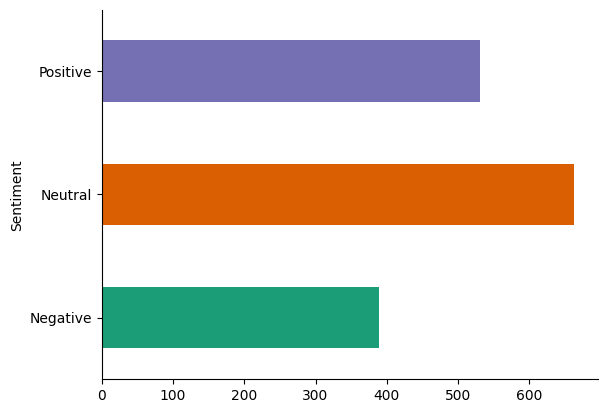

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
import pandas as pd

file_path = '/content/drive/MyDrive/roBERTa/comments_sentiment.xlsx'

df = pd.read_excel(file_path)

csv_file_path = '/content/drive/MyDrive/roBERTa/comments_sentiment.csv'
df.to_csv(csv_file_path, index=False)

print(f"File has been converted to CSV and saved to {csv_file_path}")

File has been converted to CSV and saved to /content/drive/MyDrive/roBERTa/comments_sentiment.csv
